### PSF Investigation

In [1]:
# Imports
from astropy.table import Table
import lsst.daf.butler as dafButler
import glob
import lsst.afw.table as afwTable
import matplotlib as mpl
import matplotlib.pyplot as plt
from modelling_research.plotting import plotjoint_running_percentiles
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [2]:
# Config
hsc = False
overwrite = False
gen2to3 = True
filter_inexact_psf = True
filter_interpolated = True
midfix = '_gen2to3' if gen2to3 else ''
savepre = (f'/project/dtaranu/{"cosmos/hsc" if hsc else "dc2_gen3"}'
           f'/coaddpsf/w_202{"1_02" if hsc else "0_48"}{midfix}/')
if not os.path.isdir(savepre):
    os.mkdir(savepre)
savepost = '.parq'
bands = ['g', 'r', 'i']
if hsc:
    butler = dafButler.Butler('/repo/main', collections='HSC/runs/RC2/w_2021_02/DM-28282')
    n_patches = 81
    scale_pix = 0.168
    tracts = [9615, 9697]
    # It's pointless to include COSMOS if these flags are used as 90%+ of coadd stars have them
    if not filter_inexact_psf and not filter_interpolated:
        tracts.append(9813)
    limxs = {band: x for band, x in zip(bands, ((0.525, 1.275), (0.35, 1.0), (0.35, 1.0),))}
    limsfrac = (-0.05, 0.05)
else:
    butler = dafButler.Butler('/repo/dc2', collections='2.2i/runs/test-med-1/w_2020_48/DM-27780')
    tracts = [3828, 3829]
    n_patches = 49
    scale_pix = 0.2
    filter_inexact_psf = True
    filter_interpolated = True
    limxs = {band: x for band, x in zip(bands, ((0.6, 1.2), (0.65, 0.95), (0.65, 0.95),))}
    limsfrac = (-0.025, 0.025)
patches = list(range(n_patches))

In [3]:
# Plot settings
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.figsize'] = 10, 20
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})
sns.set_style('dark')

In [4]:
# Take a sourceCatalog and turn it into a condensed parquet table
def make_summary(butler, type_cat=None, **kwargs):
    if type_cat is None:
        type_cat = 'deepCoadd_meas'
    try:
        src = butler.get(type_cat, **kwargs)
    except Exception as e:
        print(f'Failed to butler.get({type_cat}, {kwargs}) due to {e}')
        return None

    mask = src['calib_psf_used']
    n_psf = np.sum(mask)
    stars = src[mask]
    
    mask = None
    flags = [
        'base_PixelFlags_flag_clipped',
        'base_PixelFlags_flag_saturated',
    ]
    if filter_inexact_psf:
        flags.append('base_PixelFlags_flag_inexact_psf')
    if filter_interpolated:
        flags.append('base_PixelFlags_flag_interpolated')
    for flag in flags:
        if mask is None:
            mask = ~stars[flag]
        else:
            mask = mask & ~stars[flag]
        print(f'Flag {flag} filters {np.sum(stars[flag])}/{n_psf} for dataId: {kwargs}')
    print(f'Selected {np.sum(mask)}/{n_psf}')
    if np.sum(mask)==0:
        print('No data')
        return None
    stars = stars[mask]
    starIxx = stars['base_SdssShape_xx']
    starIxy = stars['base_SdssShape_xy']
    starIyy = stars['base_SdssShape_yy']
    modelIxx = stars['base_SdssShape_psf_xx']
    modelIxy = stars['base_SdssShape_psf_xy']
    modelIyy = stars['base_SdssShape_psf_yy']
    data = {}
    data['starE1'] = (starIxx-starIyy)/(starIxx+starIyy)
    data['starE2'] = (2*starIxy)/(starIxx+starIyy)
    data['starSize'] = np.sqrt(0.5*(starIxx + starIyy))*2.354820045*scale_pix
    data['modelE1'] = (modelIxx-modelIyy)/(modelIxx+modelIyy)
    data['modelE2'] = (2*modelIxy)/(modelIxx+modelIyy)
    data['modelSize'] = np.sqrt(0.5*(modelIxx + modelIyy))*2.354820045*scale_pix
    data['ra'] = [a.getCoord().getRa().asDegrees() for a in stars]
    data['dec'] = [a.getCoord().getDec().asDegrees() for a in stars]
    data['fluxPsf'] = stars['base_PsfFlux_instFlux']
    data['fluxPsfErr'] = stars['base_PsfFlux_instFluxErr']
    data['fluxCmodel'] = stars['modelfit_CModel_instFlux']
    data['fluxCmodelErr'] = stars['modelfit_CModel_instFluxErr']
    df = pd.DataFrame(data)
    return df

def make_table(band, tracts, patches, **kwargs):
    data=[]
    for tract in tracts:
        for patch in patches:
            print(f'Making summary for band={band}, tract={tract}, patch={patch}')
            result = make_summary(band=band, tract=tract, patch=patch, **kwargs)
            if result is None:
                continue
            data.append(result)
    table = pd.concat(data)
    return table

In [5]:
# Read/write data
data = {}
for band in bands:
    desc = (f'{",".join((str(x) for x in tracts))}_{band}_filt_inexact'
            f'{int(filter_inexact_psf)}_interp{int(filter_interpolated)}')
    savefile = f'{savepre}{desc}{savepost}'
    if overwrite or not os.path.exists(savefile):
        print(f'Generating {savefile} for band={band}, tracts={tracts}, patches={patches}')
        table = make_table(band, tracts, patches, butler=butler)
        table.to_parquet(savefile)
        data[band] = table
    else:
        print(f'Reading {savefile}')
        data[band] = pd.read_parquet(savefile)

Generating /project/dtaranu/dc2_gen3/coaddpsf/w_2020_48_gen2to3/3828,3829_g_filt_inexact1_interp1.parq for band=g, tracts=[3828, 3829], patches=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
Making summary for band=g, tract=3828, patch=0
Flag base_PixelFlags_flag_clipped filters 0/221 for dataId: {'band': 'g', 'tract': 3828, 'patch': 0}
Flag base_PixelFlags_flag_saturated filters 10/221 for dataId: {'band': 'g', 'tract': 3828, 'patch': 0}
Flag base_PixelFlags_flag_inexact_psf filters 69/221 for dataId: {'band': 'g', 'tract': 3828, 'patch': 0}
Flag base_PixelFlags_flag_interpolated filters 0/221 for dataId: {'band': 'g', 'tract': 3828, 'patch': 0}
Selected 152/221
Making summary for band=g, tract=3828, patch=1
Flag base_PixelFlags_flag_clipped filters 0/177 for dataId: {'band': 'g', 'tract': 3828, 'patch': 1}
Flag base_PixelFlags_flag_saturated filt

Flag base_PixelFlags_flag_clipped filters 0/245 for dataId: {'band': 'g', 'tract': 3828, 'patch': 17}
Flag base_PixelFlags_flag_saturated filters 20/245 for dataId: {'band': 'g', 'tract': 3828, 'patch': 17}
Flag base_PixelFlags_flag_inexact_psf filters 120/245 for dataId: {'band': 'g', 'tract': 3828, 'patch': 17}
Flag base_PixelFlags_flag_interpolated filters 1/245 for dataId: {'band': 'g', 'tract': 3828, 'patch': 17}
Selected 124/245
Making summary for band=g, tract=3828, patch=18
Flag base_PixelFlags_flag_clipped filters 0/229 for dataId: {'band': 'g', 'tract': 3828, 'patch': 18}
Flag base_PixelFlags_flag_saturated filters 14/229 for dataId: {'band': 'g', 'tract': 3828, 'patch': 18}
Flag base_PixelFlags_flag_inexact_psf filters 96/229 for dataId: {'band': 'g', 'tract': 3828, 'patch': 18}
Flag base_PixelFlags_flag_interpolated filters 0/229 for dataId: {'band': 'g', 'tract': 3828, 'patch': 18}
Selected 133/229
Making summary for band=g, tract=3828, patch=19
Flag base_PixelFlags_flag_c

Flag base_PixelFlags_flag_clipped filters 0/226 for dataId: {'band': 'g', 'tract': 3828, 'patch': 34}
Flag base_PixelFlags_flag_saturated filters 15/226 for dataId: {'band': 'g', 'tract': 3828, 'patch': 34}
Flag base_PixelFlags_flag_inexact_psf filters 107/226 for dataId: {'band': 'g', 'tract': 3828, 'patch': 34}
Flag base_PixelFlags_flag_interpolated filters 1/226 for dataId: {'band': 'g', 'tract': 3828, 'patch': 34}
Selected 119/226
Making summary for band=g, tract=3828, patch=35
Flag base_PixelFlags_flag_clipped filters 1/204 for dataId: {'band': 'g', 'tract': 3828, 'patch': 35}
Flag base_PixelFlags_flag_saturated filters 8/204 for dataId: {'band': 'g', 'tract': 3828, 'patch': 35}
Flag base_PixelFlags_flag_inexact_psf filters 83/204 for dataId: {'band': 'g', 'tract': 3828, 'patch': 35}
Flag base_PixelFlags_flag_interpolated filters 0/204 for dataId: {'band': 'g', 'tract': 3828, 'patch': 35}
Selected 121/204
Making summary for band=g, tract=3828, patch=36
Flag base_PixelFlags_flag_cl

Flag base_PixelFlags_flag_clipped filters 3/215 for dataId: {'band': 'g', 'tract': 3829, 'patch': 2}
Flag base_PixelFlags_flag_saturated filters 3/215 for dataId: {'band': 'g', 'tract': 3829, 'patch': 2}
Flag base_PixelFlags_flag_inexact_psf filters 71/215 for dataId: {'band': 'g', 'tract': 3829, 'patch': 2}
Flag base_PixelFlags_flag_interpolated filters 2/215 for dataId: {'band': 'g', 'tract': 3829, 'patch': 2}
Selected 144/215
Making summary for band=g, tract=3829, patch=3
Flag base_PixelFlags_flag_clipped filters 2/246 for dataId: {'band': 'g', 'tract': 3829, 'patch': 3}
Flag base_PixelFlags_flag_saturated filters 4/246 for dataId: {'band': 'g', 'tract': 3829, 'patch': 3}
Flag base_PixelFlags_flag_inexact_psf filters 80/246 for dataId: {'band': 'g', 'tract': 3829, 'patch': 3}
Flag base_PixelFlags_flag_interpolated filters 3/246 for dataId: {'band': 'g', 'tract': 3829, 'patch': 3}
Selected 164/246
Making summary for band=g, tract=3829, patch=4
Flag base_PixelFlags_flag_clipped filter

Flag base_PixelFlags_flag_clipped filters 0/216 for dataId: {'band': 'g', 'tract': 3829, 'patch': 19}
Flag base_PixelFlags_flag_saturated filters 15/216 for dataId: {'band': 'g', 'tract': 3829, 'patch': 19}
Flag base_PixelFlags_flag_inexact_psf filters 78/216 for dataId: {'band': 'g', 'tract': 3829, 'patch': 19}
Flag base_PixelFlags_flag_interpolated filters 0/216 for dataId: {'band': 'g', 'tract': 3829, 'patch': 19}
Selected 138/216
Making summary for band=g, tract=3829, patch=20
Flag base_PixelFlags_flag_clipped filters 1/223 for dataId: {'band': 'g', 'tract': 3829, 'patch': 20}
Flag base_PixelFlags_flag_saturated filters 16/223 for dataId: {'band': 'g', 'tract': 3829, 'patch': 20}
Flag base_PixelFlags_flag_inexact_psf filters 68/223 for dataId: {'band': 'g', 'tract': 3829, 'patch': 20}
Flag base_PixelFlags_flag_interpolated filters 0/223 for dataId: {'band': 'g', 'tract': 3829, 'patch': 20}
Selected 155/223
Making summary for band=g, tract=3829, patch=21
Flag base_PixelFlags_flag_cl

Flag base_PixelFlags_flag_clipped filters 0/274 for dataId: {'band': 'g', 'tract': 3829, 'patch': 36}
Flag base_PixelFlags_flag_saturated filters 13/274 for dataId: {'band': 'g', 'tract': 3829, 'patch': 36}
Flag base_PixelFlags_flag_inexact_psf filters 74/274 for dataId: {'band': 'g', 'tract': 3829, 'patch': 36}
Flag base_PixelFlags_flag_interpolated filters 1/274 for dataId: {'band': 'g', 'tract': 3829, 'patch': 36}
Selected 200/274
Making summary for band=g, tract=3829, patch=37
Flag base_PixelFlags_flag_clipped filters 3/225 for dataId: {'band': 'g', 'tract': 3829, 'patch': 37}
Flag base_PixelFlags_flag_saturated filters 13/225 for dataId: {'band': 'g', 'tract': 3829, 'patch': 37}
Flag base_PixelFlags_flag_inexact_psf filters 72/225 for dataId: {'band': 'g', 'tract': 3829, 'patch': 37}
Flag base_PixelFlags_flag_interpolated filters 0/225 for dataId: {'band': 'g', 'tract': 3829, 'patch': 37}
Selected 153/225
Making summary for band=g, tract=3829, patch=38
Flag base_PixelFlags_flag_cl

Flag base_PixelFlags_flag_clipped filters 2/231 for dataId: {'band': 'r', 'tract': 3828, 'patch': 4}
Flag base_PixelFlags_flag_saturated filters 6/231 for dataId: {'band': 'r', 'tract': 3828, 'patch': 4}
Flag base_PixelFlags_flag_inexact_psf filters 132/231 for dataId: {'band': 'r', 'tract': 3828, 'patch': 4}
Flag base_PixelFlags_flag_interpolated filters 2/231 for dataId: {'band': 'r', 'tract': 3828, 'patch': 4}
Selected 98/231
Making summary for band=r, tract=3828, patch=5
Flag base_PixelFlags_flag_clipped filters 0/257 for dataId: {'band': 'r', 'tract': 3828, 'patch': 5}
Flag base_PixelFlags_flag_saturated filters 6/257 for dataId: {'band': 'r', 'tract': 3828, 'patch': 5}
Flag base_PixelFlags_flag_inexact_psf filters 177/257 for dataId: {'band': 'r', 'tract': 3828, 'patch': 5}
Flag base_PixelFlags_flag_interpolated filters 2/257 for dataId: {'band': 'r', 'tract': 3828, 'patch': 5}
Selected 80/257
Making summary for band=r, tract=3828, patch=6
Flag base_PixelFlags_flag_clipped filter

Flag base_PixelFlags_flag_clipped filters 4/208 for dataId: {'band': 'r', 'tract': 3828, 'patch': 21}
Flag base_PixelFlags_flag_saturated filters 5/208 for dataId: {'band': 'r', 'tract': 3828, 'patch': 21}
Flag base_PixelFlags_flag_inexact_psf filters 108/208 for dataId: {'band': 'r', 'tract': 3828, 'patch': 21}
Flag base_PixelFlags_flag_interpolated filters 2/208 for dataId: {'band': 'r', 'tract': 3828, 'patch': 21}
Selected 100/208
Making summary for band=r, tract=3828, patch=22
Flag base_PixelFlags_flag_clipped filters 0/275 for dataId: {'band': 'r', 'tract': 3828, 'patch': 22}
Flag base_PixelFlags_flag_saturated filters 6/275 for dataId: {'band': 'r', 'tract': 3828, 'patch': 22}
Flag base_PixelFlags_flag_inexact_psf filters 136/275 for dataId: {'band': 'r', 'tract': 3828, 'patch': 22}
Flag base_PixelFlags_flag_interpolated filters 0/275 for dataId: {'band': 'r', 'tract': 3828, 'patch': 22}
Selected 139/275
Making summary for band=r, tract=3828, patch=23
Flag base_PixelFlags_flag_cl

Flag base_PixelFlags_flag_clipped filters 2/222 for dataId: {'band': 'r', 'tract': 3828, 'patch': 38}
Flag base_PixelFlags_flag_saturated filters 7/222 for dataId: {'band': 'r', 'tract': 3828, 'patch': 38}
Flag base_PixelFlags_flag_inexact_psf filters 140/222 for dataId: {'band': 'r', 'tract': 3828, 'patch': 38}
Flag base_PixelFlags_flag_interpolated filters 4/222 for dataId: {'band': 'r', 'tract': 3828, 'patch': 38}
Selected 80/222
Making summary for band=r, tract=3828, patch=39
Flag base_PixelFlags_flag_clipped filters 0/237 for dataId: {'band': 'r', 'tract': 3828, 'patch': 39}
Flag base_PixelFlags_flag_saturated filters 14/237 for dataId: {'band': 'r', 'tract': 3828, 'patch': 39}
Flag base_PixelFlags_flag_inexact_psf filters 130/237 for dataId: {'band': 'r', 'tract': 3828, 'patch': 39}
Flag base_PixelFlags_flag_interpolated filters 2/237 for dataId: {'band': 'r', 'tract': 3828, 'patch': 39}
Selected 106/237
Making summary for band=r, tract=3828, patch=40
Flag base_PixelFlags_flag_cl

Flag base_PixelFlags_flag_clipped filters 0/209 for dataId: {'band': 'r', 'tract': 3829, 'patch': 6}
Flag base_PixelFlags_flag_saturated filters 7/209 for dataId: {'band': 'r', 'tract': 3829, 'patch': 6}
Flag base_PixelFlags_flag_inexact_psf filters 120/209 for dataId: {'band': 'r', 'tract': 3829, 'patch': 6}
Flag base_PixelFlags_flag_interpolated filters 7/209 for dataId: {'band': 'r', 'tract': 3829, 'patch': 6}
Selected 87/209
Making summary for band=r, tract=3829, patch=7
Flag base_PixelFlags_flag_clipped filters 0/263 for dataId: {'band': 'r', 'tract': 3829, 'patch': 7}
Flag base_PixelFlags_flag_saturated filters 10/263 for dataId: {'band': 'r', 'tract': 3829, 'patch': 7}
Flag base_PixelFlags_flag_inexact_psf filters 136/263 for dataId: {'band': 'r', 'tract': 3829, 'patch': 7}
Flag base_PixelFlags_flag_interpolated filters 5/263 for dataId: {'band': 'r', 'tract': 3829, 'patch': 7}
Selected 126/263
Making summary for band=r, tract=3829, patch=8
Flag base_PixelFlags_flag_clipped filt

Making summary for band=r, tract=3829, patch=23
Flag base_PixelFlags_flag_clipped filters 0/246 for dataId: {'band': 'r', 'tract': 3829, 'patch': 23}
Flag base_PixelFlags_flag_saturated filters 13/246 for dataId: {'band': 'r', 'tract': 3829, 'patch': 23}
Flag base_PixelFlags_flag_inexact_psf filters 132/246 for dataId: {'band': 'r', 'tract': 3829, 'patch': 23}
Flag base_PixelFlags_flag_interpolated filters 3/246 for dataId: {'band': 'r', 'tract': 3829, 'patch': 23}
Selected 113/246
Making summary for band=r, tract=3829, patch=24
Flag base_PixelFlags_flag_clipped filters 1/260 for dataId: {'band': 'r', 'tract': 3829, 'patch': 24}
Flag base_PixelFlags_flag_saturated filters 6/260 for dataId: {'band': 'r', 'tract': 3829, 'patch': 24}
Flag base_PixelFlags_flag_inexact_psf filters 149/260 for dataId: {'band': 'r', 'tract': 3829, 'patch': 24}
Flag base_PixelFlags_flag_interpolated filters 5/260 for dataId: {'band': 'r', 'tract': 3829, 'patch': 24}
Selected 111/260
Making summary for band=r, 

Flag base_PixelFlags_flag_clipped filters 2/244 for dataId: {'band': 'r', 'tract': 3829, 'patch': 40}
Flag base_PixelFlags_flag_saturated filters 0/244 for dataId: {'band': 'r', 'tract': 3829, 'patch': 40}
Flag base_PixelFlags_flag_inexact_psf filters 134/244 for dataId: {'band': 'r', 'tract': 3829, 'patch': 40}
Flag base_PixelFlags_flag_interpolated filters 4/244 for dataId: {'band': 'r', 'tract': 3829, 'patch': 40}
Selected 110/244
Making summary for band=r, tract=3829, patch=41
Flag base_PixelFlags_flag_clipped filters 2/223 for dataId: {'band': 'r', 'tract': 3829, 'patch': 41}
Flag base_PixelFlags_flag_saturated filters 5/223 for dataId: {'band': 'r', 'tract': 3829, 'patch': 41}
Flag base_PixelFlags_flag_inexact_psf filters 107/223 for dataId: {'band': 'r', 'tract': 3829, 'patch': 41}
Flag base_PixelFlags_flag_interpolated filters 1/223 for dataId: {'band': 'r', 'tract': 3829, 'patch': 41}
Selected 115/223
Making summary for band=r, tract=3829, patch=42
Flag base_PixelFlags_flag_cl

Flag base_PixelFlags_flag_clipped filters 0/222 for dataId: {'band': 'i', 'tract': 3828, 'patch': 8}
Flag base_PixelFlags_flag_saturated filters 14/222 for dataId: {'band': 'i', 'tract': 3828, 'patch': 8}
Flag base_PixelFlags_flag_inexact_psf filters 161/222 for dataId: {'band': 'i', 'tract': 3828, 'patch': 8}
Flag base_PixelFlags_flag_interpolated filters 3/222 for dataId: {'band': 'i', 'tract': 3828, 'patch': 8}
Selected 59/222
Making summary for band=i, tract=3828, patch=9
Flag base_PixelFlags_flag_clipped filters 1/252 for dataId: {'band': 'i', 'tract': 3828, 'patch': 9}
Flag base_PixelFlags_flag_saturated filters 11/252 for dataId: {'band': 'i', 'tract': 3828, 'patch': 9}
Flag base_PixelFlags_flag_inexact_psf filters 198/252 for dataId: {'band': 'i', 'tract': 3828, 'patch': 9}
Flag base_PixelFlags_flag_interpolated filters 13/252 for dataId: {'band': 'i', 'tract': 3828, 'patch': 9}
Selected 53/252
Making summary for band=i, tract=3828, patch=10
Flag base_PixelFlags_flag_clipped fi

Flag base_PixelFlags_flag_clipped filters 2/241 for dataId: {'band': 'i', 'tract': 3828, 'patch': 25}
Flag base_PixelFlags_flag_saturated filters 12/241 for dataId: {'band': 'i', 'tract': 3828, 'patch': 25}
Flag base_PixelFlags_flag_inexact_psf filters 180/241 for dataId: {'band': 'i', 'tract': 3828, 'patch': 25}
Flag base_PixelFlags_flag_interpolated filters 5/241 for dataId: {'band': 'i', 'tract': 3828, 'patch': 25}
Selected 60/241
Making summary for band=i, tract=3828, patch=26
Flag base_PixelFlags_flag_clipped filters 2/247 for dataId: {'band': 'i', 'tract': 3828, 'patch': 26}
Flag base_PixelFlags_flag_saturated filters 16/247 for dataId: {'band': 'i', 'tract': 3828, 'patch': 26}
Flag base_PixelFlags_flag_inexact_psf filters 186/247 for dataId: {'band': 'i', 'tract': 3828, 'patch': 26}
Flag base_PixelFlags_flag_interpolated filters 9/247 for dataId: {'band': 'i', 'tract': 3828, 'patch': 26}
Selected 59/247
Making summary for band=i, tract=3828, patch=27
Flag base_PixelFlags_flag_cl

Flag base_PixelFlags_flag_clipped filters 1/232 for dataId: {'band': 'i', 'tract': 3828, 'patch': 42}
Flag base_PixelFlags_flag_saturated filters 8/232 for dataId: {'band': 'i', 'tract': 3828, 'patch': 42}
Flag base_PixelFlags_flag_inexact_psf filters 189/232 for dataId: {'band': 'i', 'tract': 3828, 'patch': 42}
Flag base_PixelFlags_flag_interpolated filters 6/232 for dataId: {'band': 'i', 'tract': 3828, 'patch': 42}
Selected 43/232
Making summary for band=i, tract=3828, patch=43
Flag base_PixelFlags_flag_clipped filters 0/238 for dataId: {'band': 'i', 'tract': 3828, 'patch': 43}
Flag base_PixelFlags_flag_saturated filters 15/238 for dataId: {'band': 'i', 'tract': 3828, 'patch': 43}
Flag base_PixelFlags_flag_inexact_psf filters 178/238 for dataId: {'band': 'i', 'tract': 3828, 'patch': 43}
Flag base_PixelFlags_flag_interpolated filters 3/238 for dataId: {'band': 'i', 'tract': 3828, 'patch': 43}
Selected 59/238
Making summary for band=i, tract=3828, patch=44
Flag base_PixelFlags_flag_cli

Flag base_PixelFlags_flag_clipped filters 2/218 for dataId: {'band': 'i', 'tract': 3829, 'patch': 10}
Flag base_PixelFlags_flag_saturated filters 4/218 for dataId: {'band': 'i', 'tract': 3829, 'patch': 10}
Flag base_PixelFlags_flag_inexact_psf filters 137/218 for dataId: {'band': 'i', 'tract': 3829, 'patch': 10}
Flag base_PixelFlags_flag_interpolated filters 4/218 for dataId: {'band': 'i', 'tract': 3829, 'patch': 10}
Selected 81/218
Making summary for band=i, tract=3829, patch=11
Flag base_PixelFlags_flag_clipped filters 0/271 for dataId: {'band': 'i', 'tract': 3829, 'patch': 11}
Flag base_PixelFlags_flag_saturated filters 6/271 for dataId: {'band': 'i', 'tract': 3829, 'patch': 11}
Flag base_PixelFlags_flag_inexact_psf filters 160/271 for dataId: {'band': 'i', 'tract': 3829, 'patch': 11}
Flag base_PixelFlags_flag_interpolated filters 4/271 for dataId: {'band': 'i', 'tract': 3829, 'patch': 11}
Selected 109/271
Making summary for band=i, tract=3829, patch=12
Flag base_PixelFlags_flag_cli

Flag base_PixelFlags_flag_clipped filters 0/218 for dataId: {'band': 'i', 'tract': 3829, 'patch': 27}
Flag base_PixelFlags_flag_saturated filters 5/218 for dataId: {'band': 'i', 'tract': 3829, 'patch': 27}
Flag base_PixelFlags_flag_inexact_psf filters 159/218 for dataId: {'band': 'i', 'tract': 3829, 'patch': 27}
Flag base_PixelFlags_flag_interpolated filters 6/218 for dataId: {'band': 'i', 'tract': 3829, 'patch': 27}
Selected 59/218
Making summary for band=i, tract=3829, patch=28
Flag base_PixelFlags_flag_clipped filters 1/224 for dataId: {'band': 'i', 'tract': 3829, 'patch': 28}
Flag base_PixelFlags_flag_saturated filters 4/224 for dataId: {'band': 'i', 'tract': 3829, 'patch': 28}
Flag base_PixelFlags_flag_inexact_psf filters 123/224 for dataId: {'band': 'i', 'tract': 3829, 'patch': 28}
Flag base_PixelFlags_flag_interpolated filters 7/224 for dataId: {'band': 'i', 'tract': 3829, 'patch': 28}
Selected 98/224
Making summary for band=i, tract=3829, patch=29
Flag base_PixelFlags_flag_clip

Flag base_PixelFlags_flag_clipped filters 0/234 for dataId: {'band': 'i', 'tract': 3829, 'patch': 44}
Flag base_PixelFlags_flag_saturated filters 0/234 for dataId: {'band': 'i', 'tract': 3829, 'patch': 44}
Flag base_PixelFlags_flag_inexact_psf filters 135/234 for dataId: {'band': 'i', 'tract': 3829, 'patch': 44}
Flag base_PixelFlags_flag_interpolated filters 4/234 for dataId: {'band': 'i', 'tract': 3829, 'patch': 44}
Selected 96/234
Making summary for band=i, tract=3829, patch=45
Flag base_PixelFlags_flag_clipped filters 0/235 for dataId: {'band': 'i', 'tract': 3829, 'patch': 45}
Flag base_PixelFlags_flag_saturated filters 7/235 for dataId: {'band': 'i', 'tract': 3829, 'patch': 45}
Flag base_PixelFlags_flag_inexact_psf filters 132/235 for dataId: {'band': 'i', 'tract': 3829, 'patch': 45}
Flag base_PixelFlags_flag_interpolated filters 3/235 for dataId: {'band': 'i', 'tract': 3829, 'patch': 45}
Selected 101/235
Making summary for band=i, tract=3829, patch=46
Flag base_PixelFlags_flag_cli

g Lanczos5 PSF model residuals (N=13223)


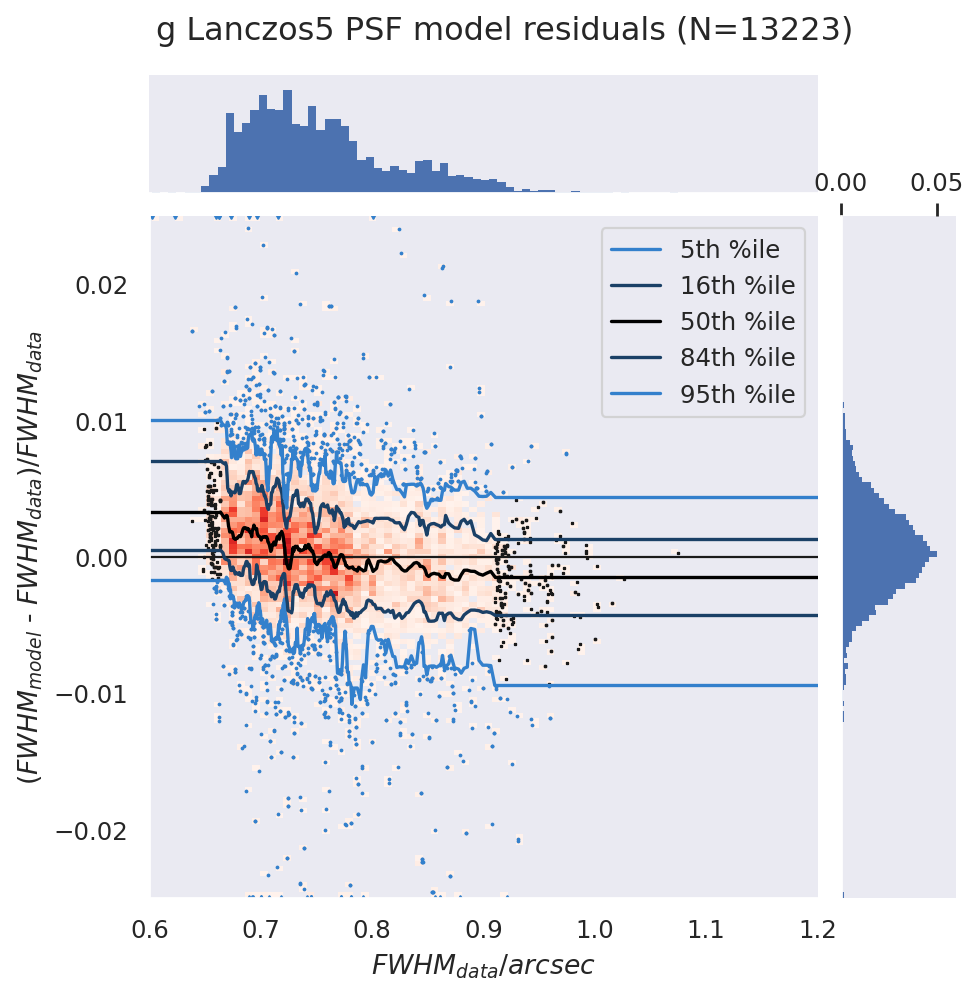

r Lanczos5 PSF model residuals (N=10623)


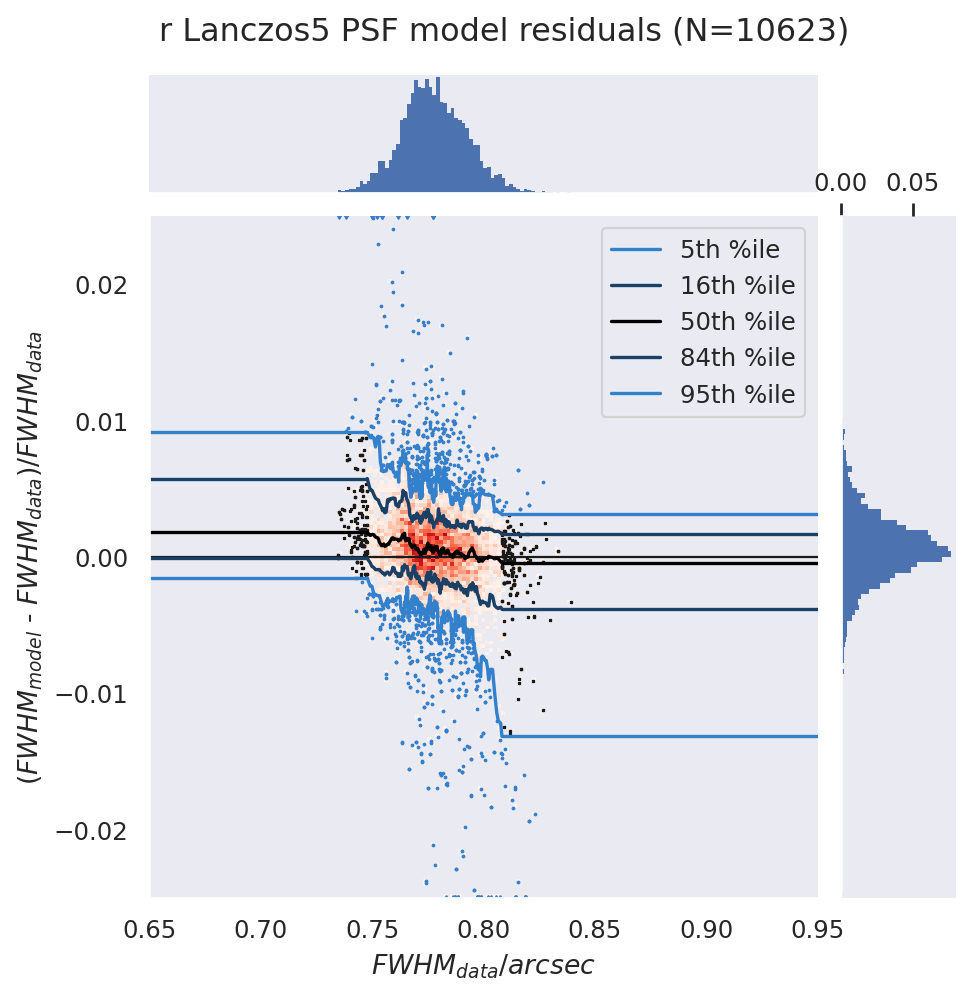

i Lanczos5 PSF model residuals (N=7511)


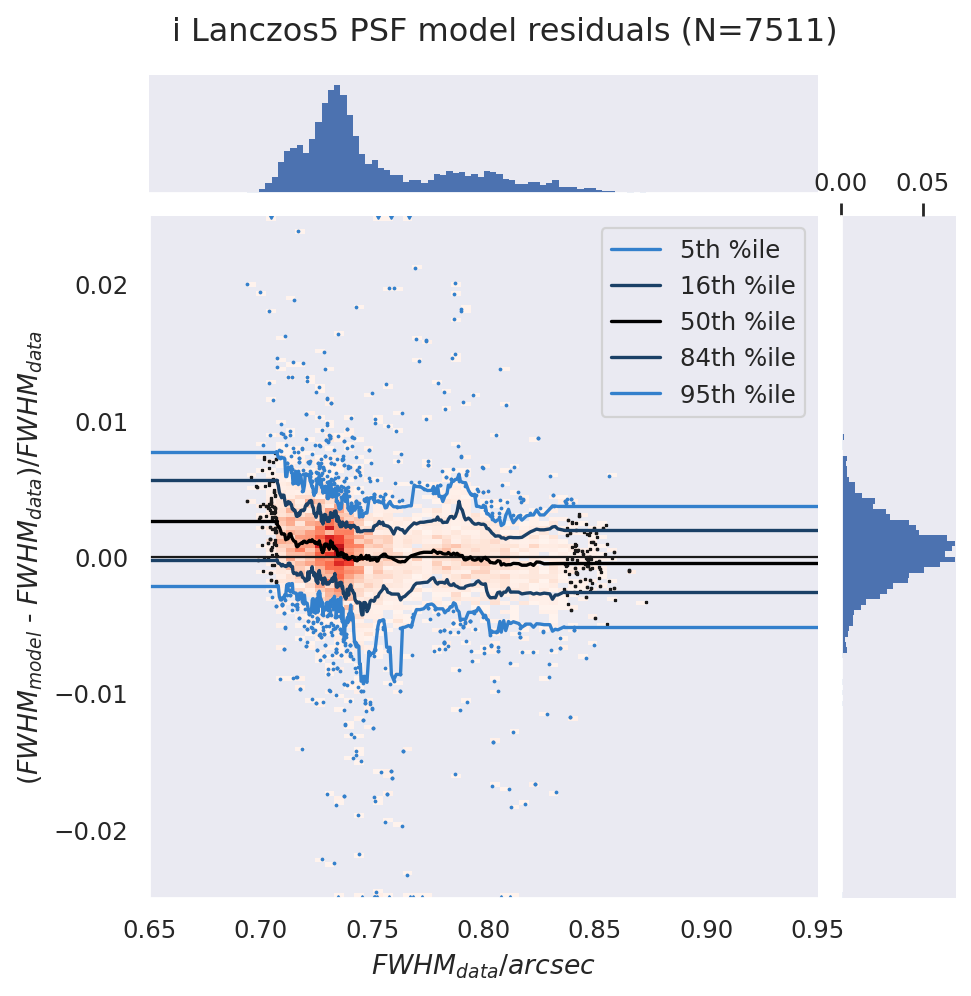

g Lanczos5, 0.602 <= FWHM <= 0.704, N=3304


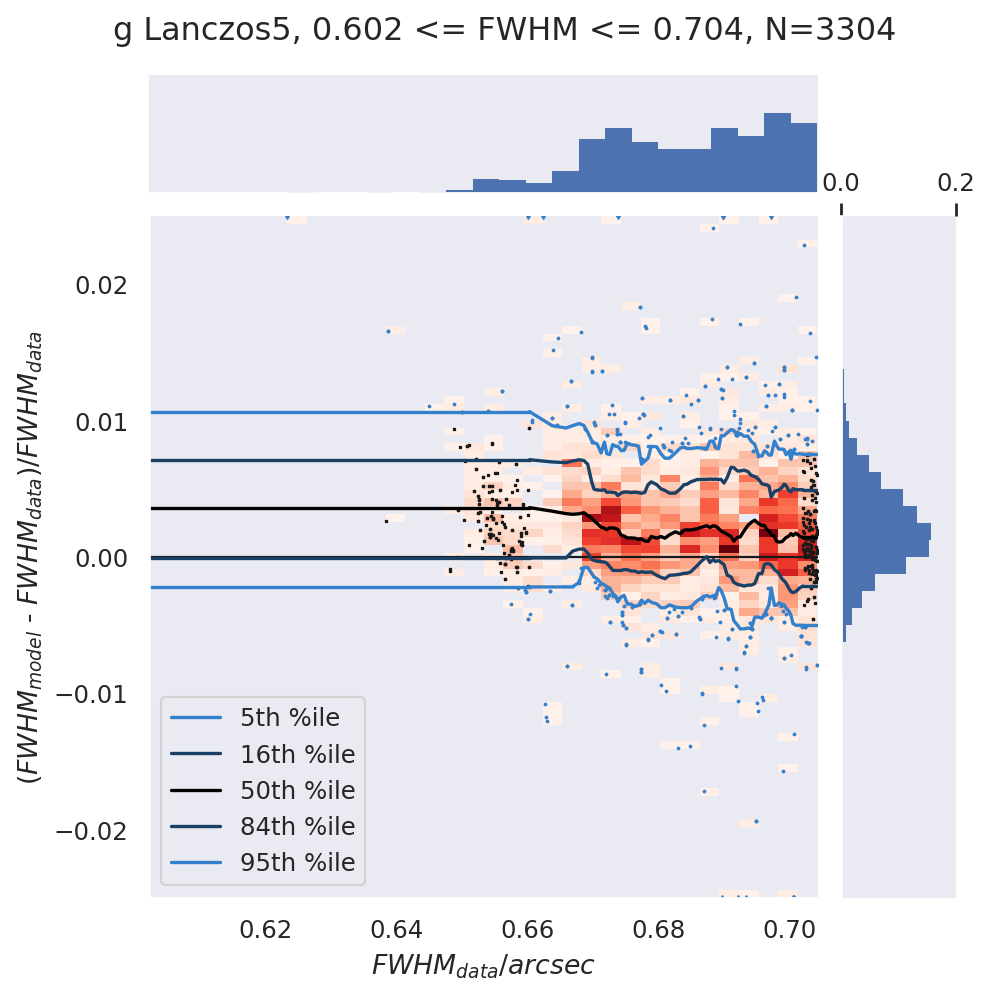

g Lanczos5, 0.704 <= FWHM <= 0.742, N=3303


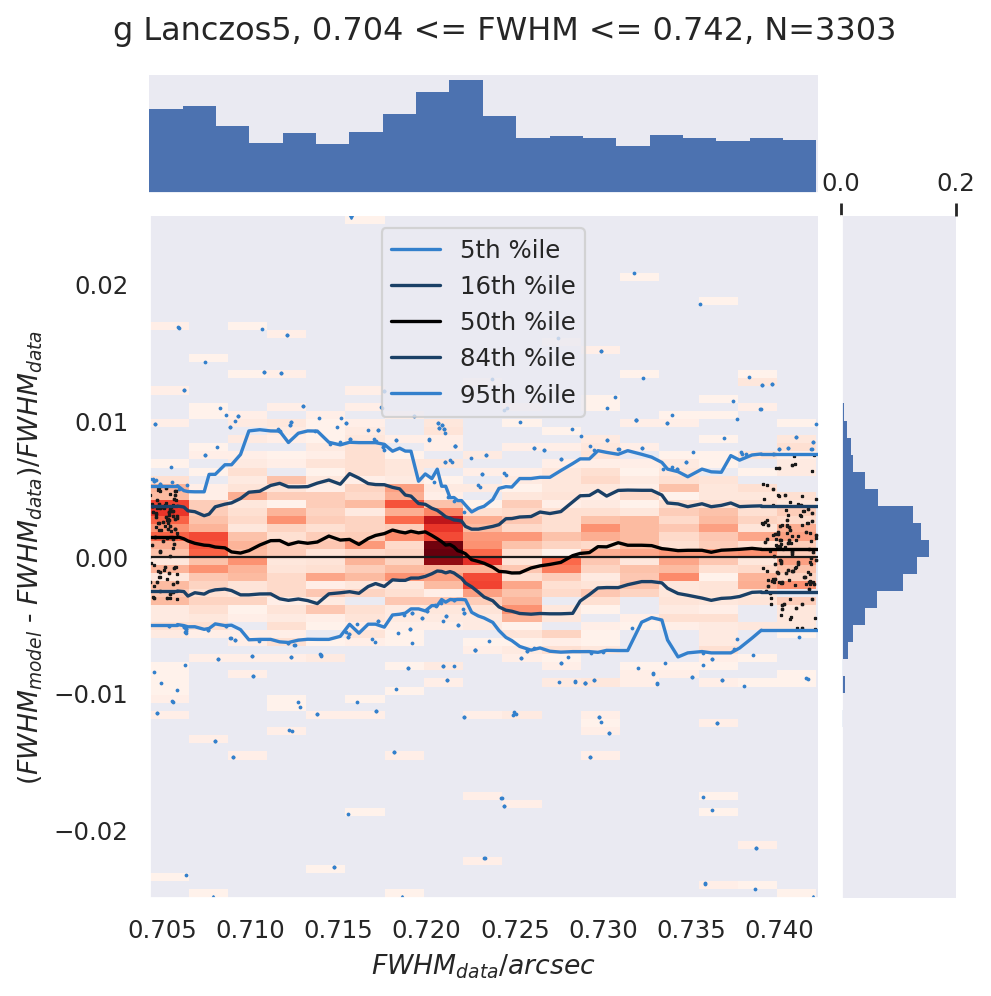

g Lanczos5, 0.742 <= FWHM <= 0.787, N=3303


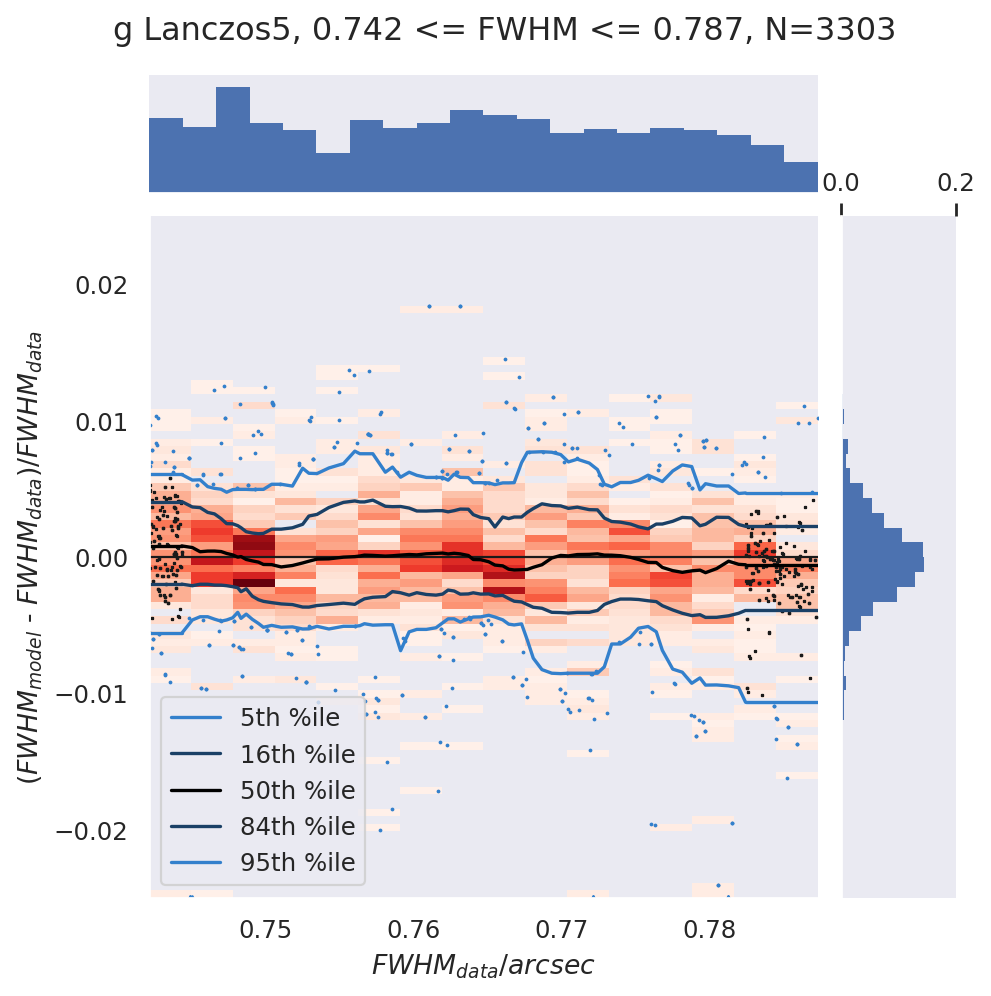

g Lanczos5, 0.787 <= FWHM <= 1.075, N=3304


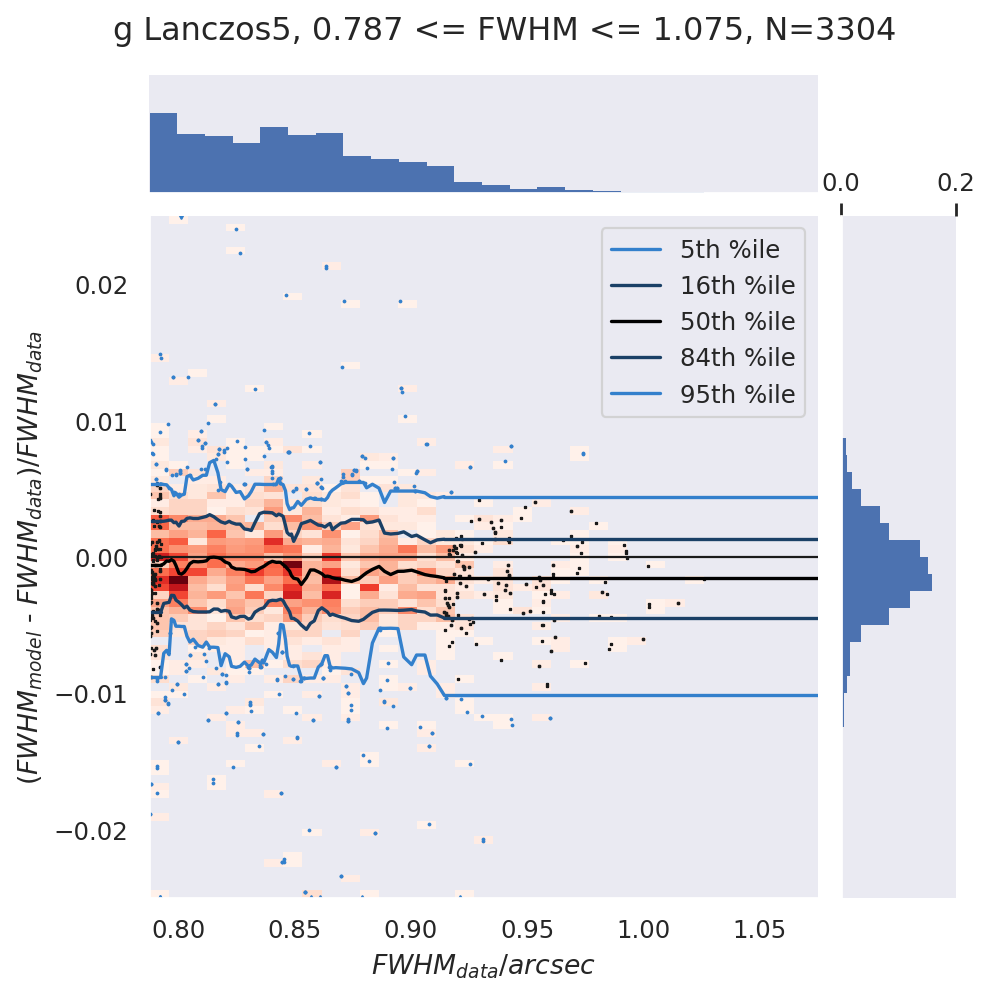

r Lanczos5, 0.735 <= FWHM <= 0.768, N=2655


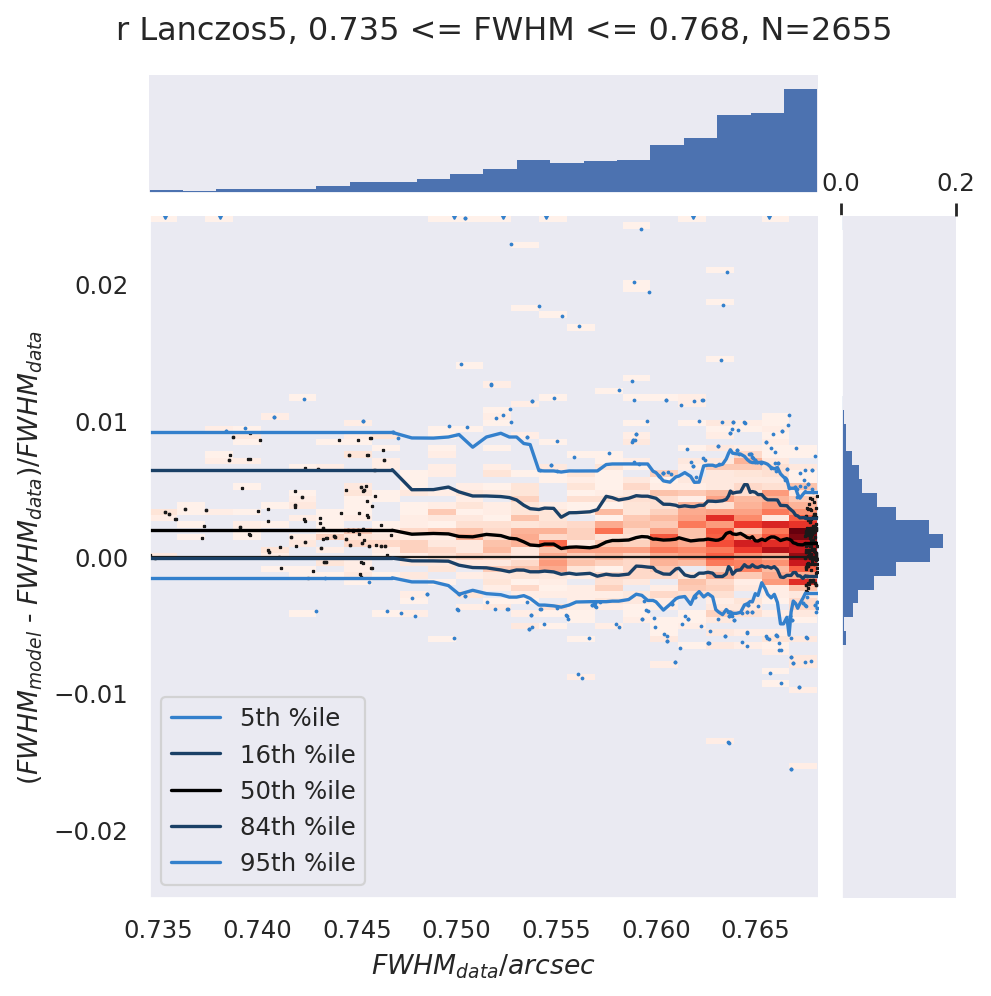

r Lanczos5, 0.768 <= FWHM <= 0.777, N=2654


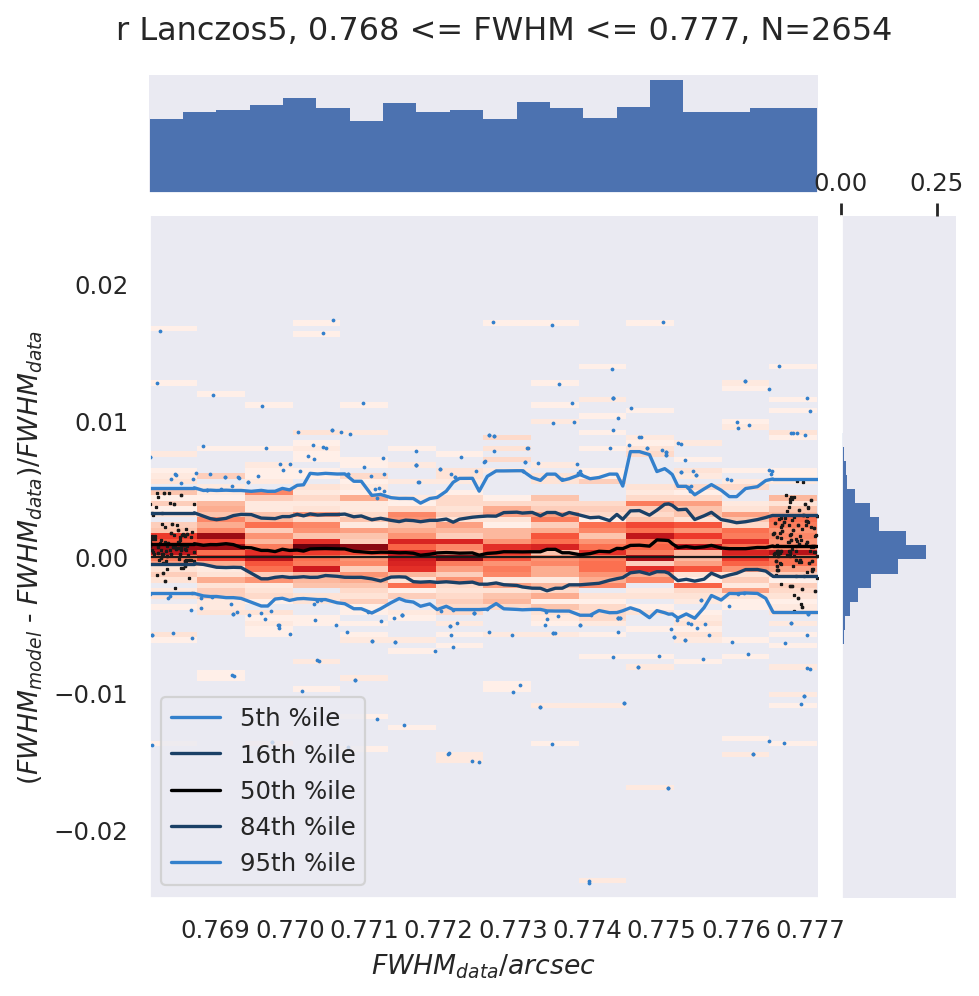

r Lanczos5, 0.777 <= FWHM <= 0.788, N=2654


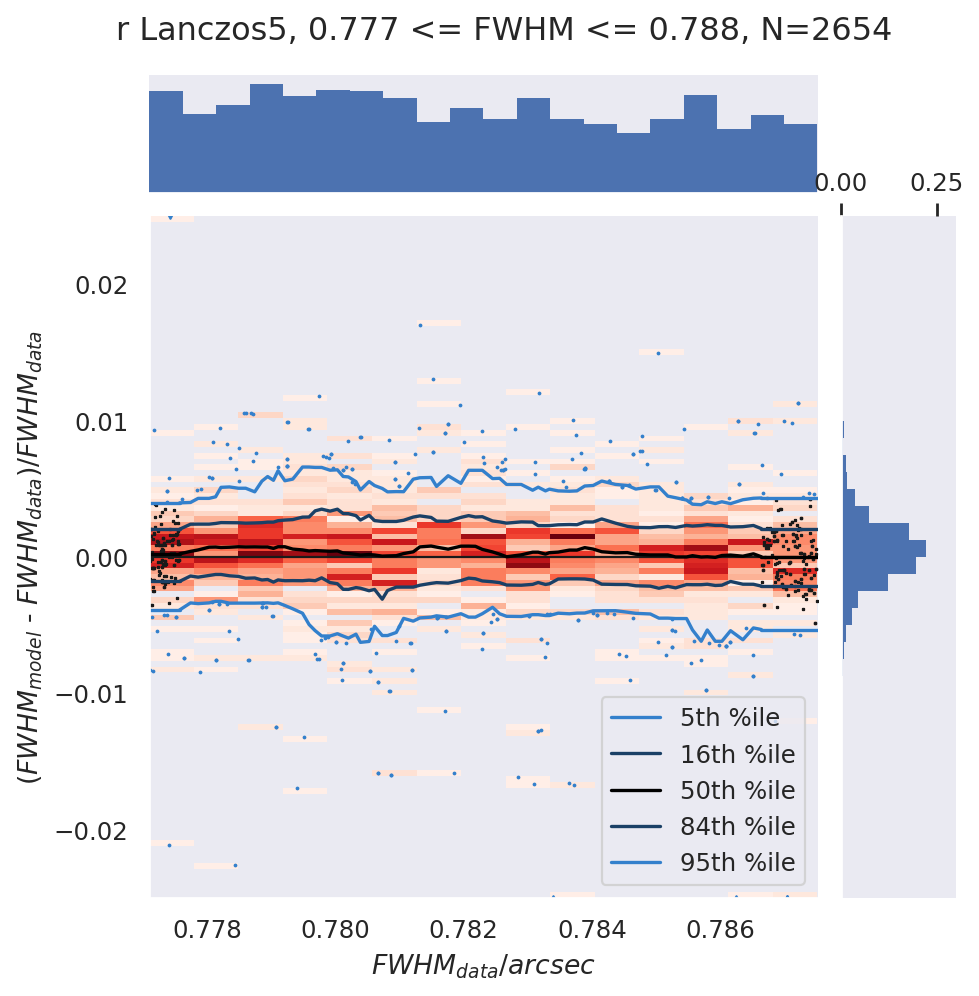

r Lanczos5, 0.788 <= FWHM <= 0.839, N=2655


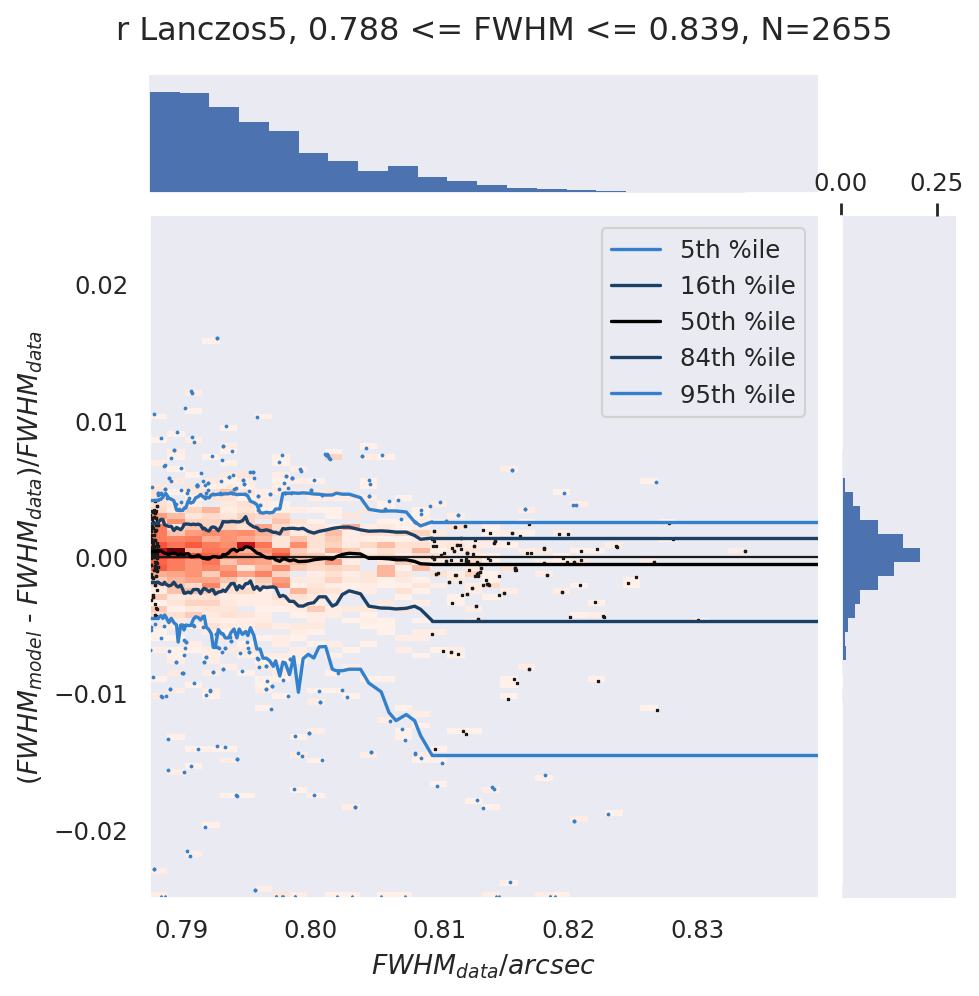

i Lanczos5, 0.694 <= FWHM <= 0.728, N=1877


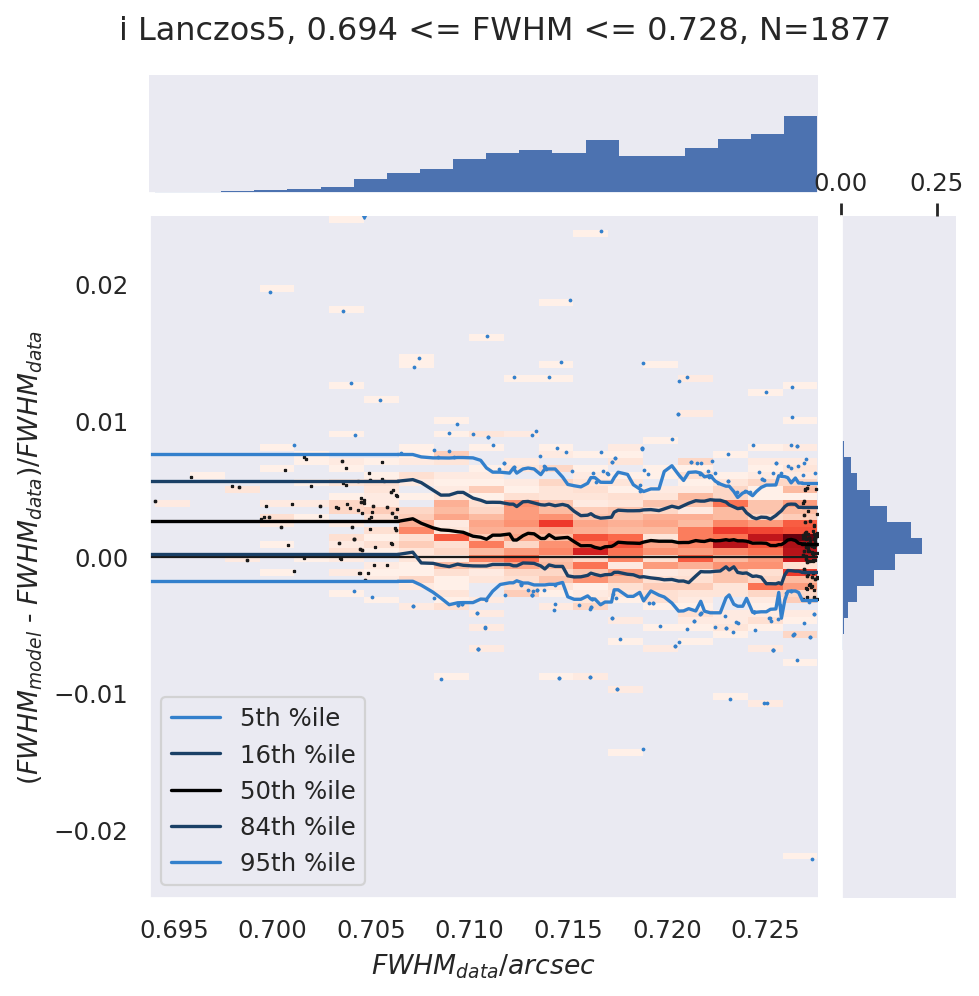

i Lanczos5, 0.728 <= FWHM <= 0.738, N=1875


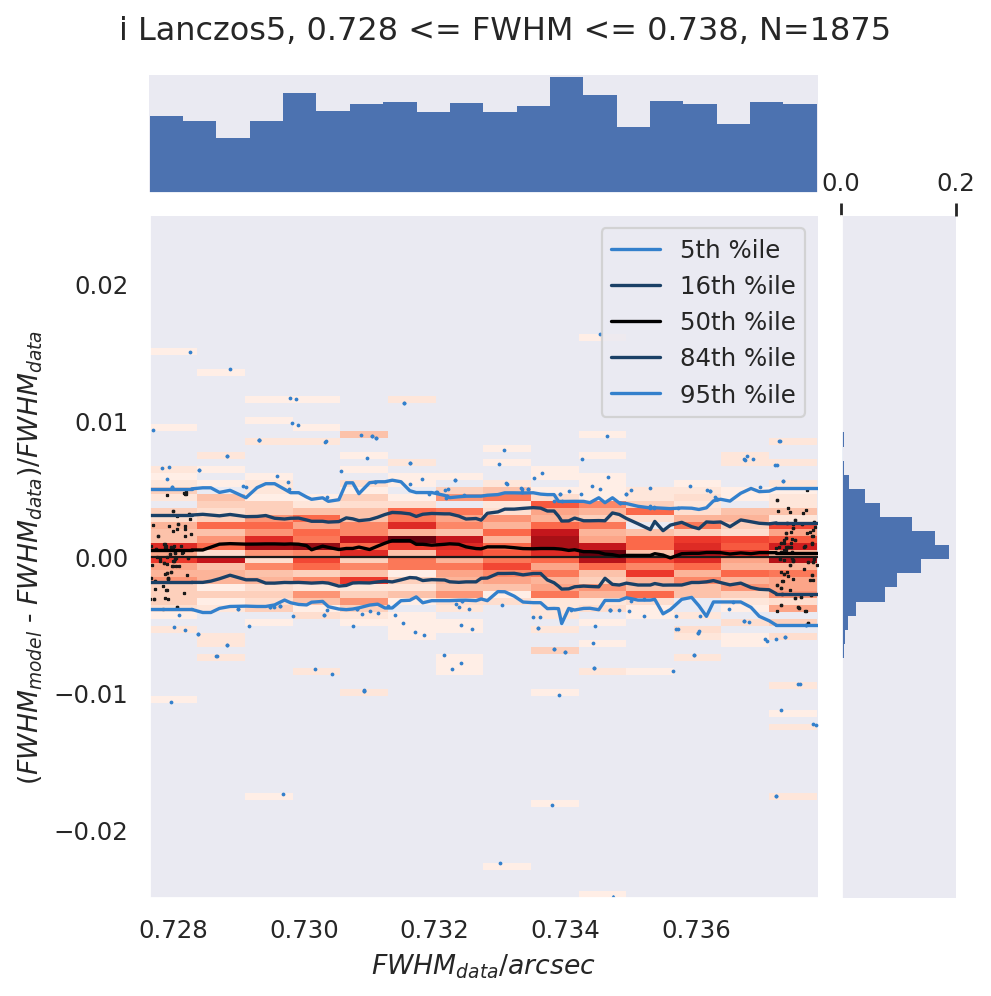

i Lanczos5, 0.738 <= FWHM <= 0.770, N=1876


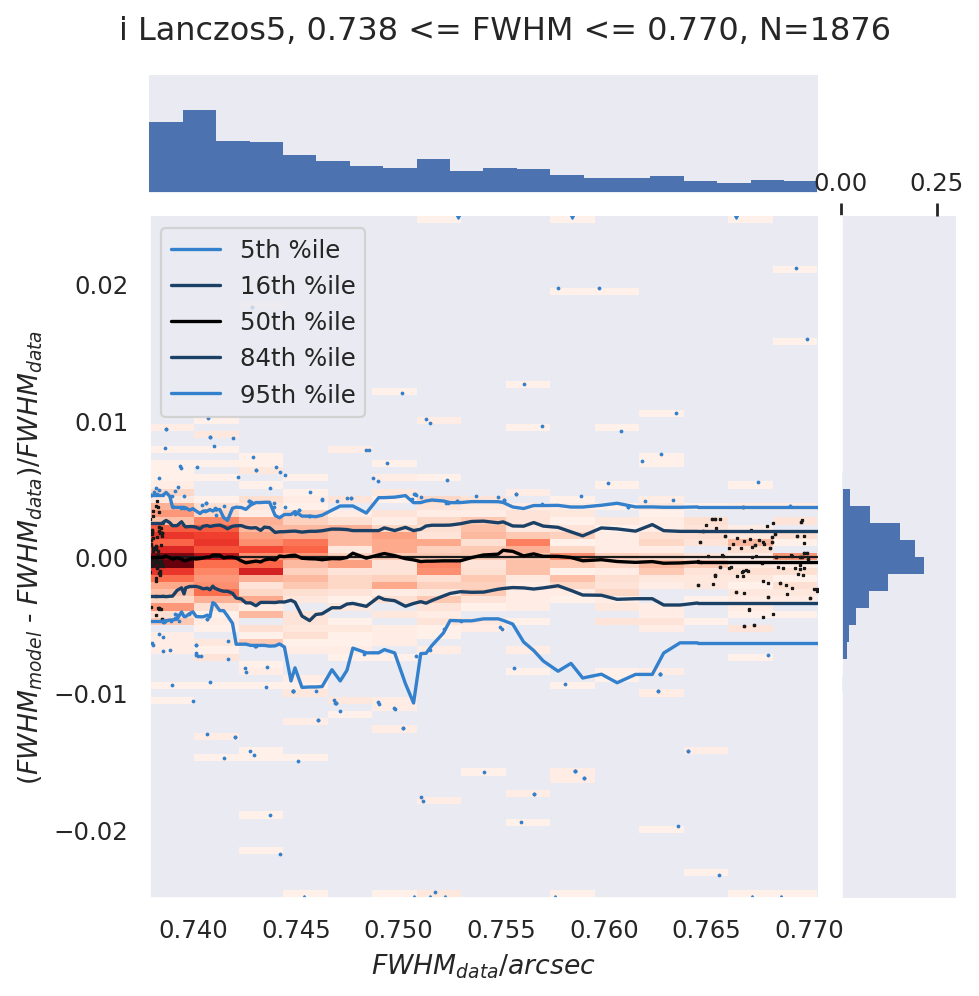

i Lanczos5, 0.770 <= FWHM <= 0.873, N=1877


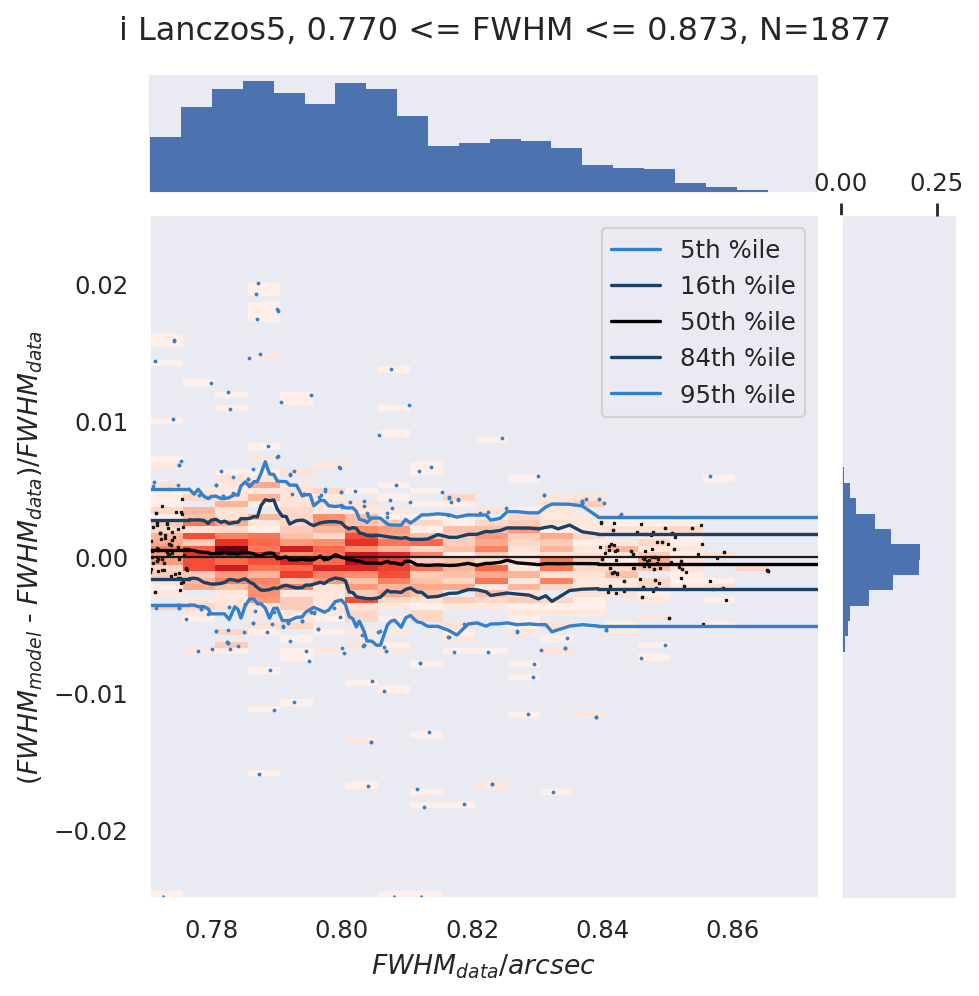

In [6]:
# Plot
kwargs_plotjoint = dict(
    nbinspan = 8,
    densityplot=sns.histplot,
    cmap='Reds',
    limy=limsfrac,
    scatterleft=True,
    scatterright=True,
)
plot_patch = False
labelflux = 'log10(instFluxPsf)'
labelsizeresid = r'($FWHM_{model}$ - $FWHM_{data}$)/$FWHM_{data}$'
labelsize = r'$FWHM_{data}/arcsec$'

for dataplot, typeofdata in ((data, 'Lanczos5'),):
    for band, limx in limxs.items():
        datum = dataplot[band]
        limx = limxs[band]
        x = np.clip(datum['starSize'], limx[0], limx[1])
        sizefrac = (datum['modelSize'] - datum['starSize'])/datum['starSize']
        title=f'{band} {typeofdata} PSF model residuals (N={len(x)})'
        print(title)
        plotjoint_running_percentiles(
            x, sizefrac, limx=limx, ndivisions=32,
            labelx=labelsize, labely=labelsizeresid, title=title,
            **kwargs_plotjoint
        )
        plt.show()
        
for dataplot, typeofdata in ((data, 'Lanczos5'),):
    for band, limx in limxs.items():
        datum = dataplot[band]
        sizefrac = (datum['modelSize'] - datum['starSize'])/datum['starSize']
        condsizefrac = np.isfinite(sizefrac) & np.isfinite(datum['fluxPsf']) & (datum['starSize']<2)
        sizebins = np.sort(datum['starSize'][condsizefrac])[
            np.asarray(np.round(np.linspace(0, np.sum(condsizefrac)-1, num=4+1)), dtype=int)
        ]
        for idx in range(len(sizebins) - 1):
            sizemin, sizemax = sizebins[idx:idx+2]
            cond = condsizefrac & (datum['starSize'] > sizemin) & (datum['starSize'] < sizemax)
            numpoints = np.sum(cond)
            title = f'{band} {typeofdata}, {sizemin:.3f} <= FWHM <= {sizemax:.3f}, N={numpoints}'
            if numpoints >= 100:    
                print(title)
                x = datum['starSize'][cond]
                y = sizefrac[cond]
                plotjoint_running_percentiles(
                    x, y, limx=(sizemin, sizemax), ndivisions=10,
                    labelx=labelsize, labely=labelsizeresid, title=title,
                    **kwargs_plotjoint
                )
                plt.show()
        if plot_patch:
            # TODO: Make sensible plots per patch
            for patch in patches:
                cond = (datum['file'] == patch) & condsizefrac
                grid = sns.jointplot(
                    np.log10(datum['fluxPsf'][cond]), sizefrac[cond], ylim=[-0.1, 0.1],
                    stat_func=None, size=4, s=1, marginal_kws={'bins': 30},
                )
                grid.fig.suptitle(band)